# basic
## 参考资料
[Jay Alammar的图解Transformer](https://jalammar.github.io/illustrated-transformer/ "适合入门")

[Jay Alammar对应中文版](https://blog.csdn.net/weixin_42475060/article/details/121101749 "建议直接看原版")

## transformer结构
包含输入、Encoder block、Decoder block和输出四部分组成

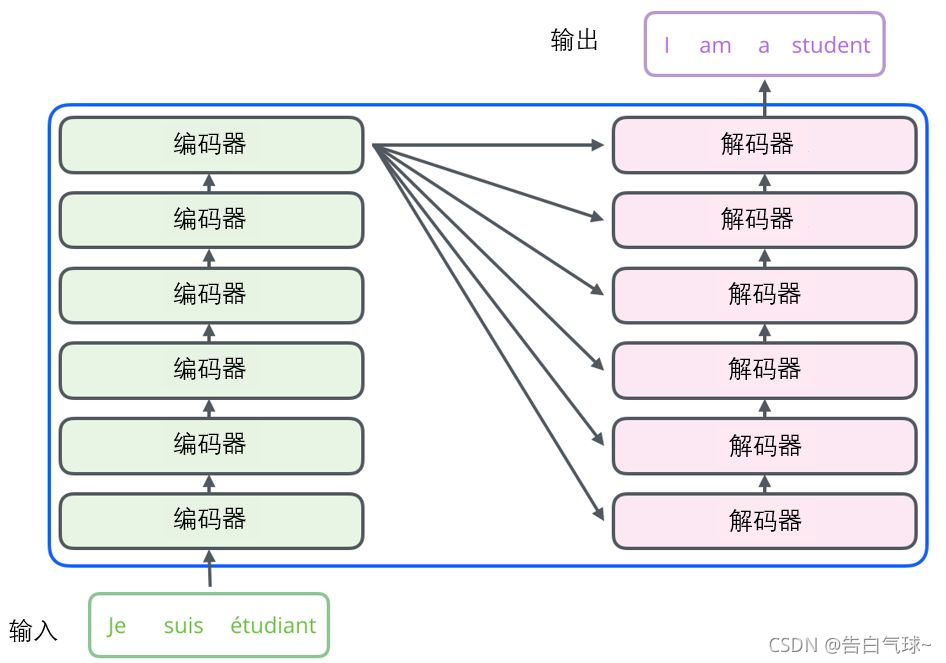

## 自注意力机制
具体步骤看[Jay Alammar的图解Transformer](https://jalammar.github.io/illustrated-transformer/ "适合入门")
1. 利用输入向量乘以三个矩阵得到三个向量（Q,K,V）。例如输入（1，512），矩阵（512，64），QKV大小都是（1，64）
2. 利用Q和K点积计算两个输入之间的分数（一个数字）。例如$q_1 \cdot k_1$表示第一个输入与第一个输入之间的关系，$q_1 \cdot k_2$表示第一个输入与第二个输入之间的关系
3. 将第二步计算得到的分数统一除以$\sqrt{d_k}$,避免梯度消失，防止个别值太大，导致经过softmax后趋近于1，而其他值趋近于0.
4. 进行softmax，保证每一个分数都大于0，并且一个输入与所有输入的分数和为1.
5. 将每个值向量与对应的softmax分数相乘。可以理解为保持要关注的位置值不变，淹没不相关的位置值。
6. 对加权值向量求和，得到对应位置的输出。

矩阵实现：
输入x $（n,d_k）$，矩阵$W^Q,W^K,W^V$ 为 $(d_k, d_k / h)$,则QKV对应的大小为$(n,d_k/h)$,整体公式可以表示为：
$$\text{softmax} (\frac{Q \cdot K^T}{\sqrt{d_k}})V$$

## 多头注意力机制
多头注意力机制本质上是多个自注意力机制
1. 利用输出向量（batch_size,seq_len,embed_dim）乘以三个矩阵得到Q,K,V,维度都是（batch_size,seq_len,embed_dim）。
2. 将Q,K,V拆分为多个头（batch_size,seq_len,embed_dim）->(batch_size,seq_len,head_num,head_dim)->(bbatch_size,head_num,seq_len,head_dim).最后一步是为了计算$Q \cdot K^T$
3. 计算$\frac{Q \cdot K^T}{\sqrt{d_k}}$
4. 判断是否有注意力掩膜
5. softmax
6. dropout
7. 乘以V，输出层

自注意力机制实现：四重境界
参考资料：[手写Self-Attention的四重境界](https://bruceyuan.com/hands-on-code/from-self-attention-to-multi-head-self-attention.html "chaofa用代码打点酱油")

1. 最简单版本

In [31]:
import torch
import math
from torch import nn
import torch.nn.functional as F

class selfAttention1(nn.Module):
    def __init__(self, embed_dim=512, emd_dim=64):
        super().__init__()
        self.embed_dim = embed_dim
        self.linerQ = nn.Linear(embed_dim, emd_dim)
        self.LinerK = nn.Linear(embed_dim, emd_dim)
        self.LinerV = nn.Linear(embed_dim, emd_dim)

    def forward(self, x):
        Q = self.linerQ(x)
        K = self.LinerK(x)
        V = self.LinerV(x)

        attention = torch.matmul(Q, K.transpose(-1,-2)) / math.sqrt(self.embed_dim)

        attention = F.softmax(attention, dim=-1)

        output = torch.matmul(attention, V)
        return output

x = torch.randn(8,4,512)
model = selfAttention1()
output = model(x)
print("output size is ", output.size())

output size is  torch.Size([8, 4, 64])


2. 矩阵优化
将QKV三个参数矩阵统一成一个大的矩阵，之后将结果拆分成Q,K,V

In [32]:
import torch
import torch.nn.functional as F
from torch import nn
import math

class SelfAttention2(nn.Module):
    def __init__(self,embed_dim=512,head_dim=64):
        super().__init__()
        """
        实现自注意力机制，QKV大矩阵实现。
        embed_dim：输入维度
        head_dim：中间维度、输出维度
        """
        self.embed_dim = embed_dim
        self.head_dim = head_dim
        self.linear = nn.Linear(embed_dim, 3 * head_dim)

    def forward(self, x):
        QKV = self.linear(x)
        Q, K, V = QKV.split(self.head_dim, dim=-1)
        # softmax注意加dim。三维及以上矩阵转换维度使用transpose。
        attention = F.softmax(torch.matmul(Q, K.transpose(-1,-2)) / math.sqrt(self.head_dim), dim=-1)

        output = torch.matmul(attention, V)

        return output
    
x = torch.randn(8, 4, 512)
model = SelfAttention2()
output = model(x)
print(output.size())

torch.Size([8, 4, 64])


3. 加入一些细节
* dropout
* attention_mask
* 输出映射层

In [33]:
import torch
import torch.nn.functional as F
from torch import nn
import math
from typing import Optional


class SelfAttention3(nn.Module):
    def __init__(self, embed_dim: int = 512, head_dim: int = 64, dropout: float = 0.1):
        """
        Args:
            embed_dim:输入的嵌入维度
            head_dim:中间维度
            dropout：丢弃率
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = head_dim
        self.linear = nn.Linear(embed_dim, 3 * head_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """单头自注意力机制

        Args:
            x (torch.tensor): 输入特征（batch_size, seq_len, embed_dim）
            mask (Optional[torch.tensor], optional): 注意力掩膜,0/1组成，（batch_size, n, embed_dim）. Defaults to None.

        Returns:
            torch.tensor: (batch_size, seq_len, head_dim))
        """
        batch_size, seq_len, _ = x.size()

        # 计算Q，K，V
        QKV = self.linear(x)  # （batch_size, seq_len, 3 * head_dim
        Q, K, V = QKV.split(self.head_dim, dim=-1)  # 各(batch_size, seq_len, head_dim) 

        # 计算注意力分数
        attention = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)  #(batch_size, seq_len, seq_len)

        # 计算掩膜
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e9)

        # 计算注意力权重
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)

        # 计算输出 
        output = torch.matmul(attention, V)  #[batch_size, seq_len, head_dim]

        return output
    

x = torch.randn(8, 4, 512)
model = SelfAttention3()
output = model(x)
print(output.size())
a = torch.tensor([[0,1,0],[1,0,1]])
print(a.size())
print(a==0)

torch.Size([8, 4, 64])
torch.Size([2, 3])
tensor([[ True, False,  True],
        [False,  True, False]])


4. 多头注意力机制

In [34]:
import torch
import torch.nn.functional as F
from torch import nn
import math
from typing import Optional

class SelfAttention4(nn.Module):
    def __init__(self, embed_dim: int=512, head_num: int=8, dropout: float=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.head_num = head_num
        self.head_dim = embed_dim // head_num
        assert embed_dim == head_num * self.head_dim, f"embed_dim {embed_dim} must can be dived by head_num {head_num}"
        self.dropout = nn.Dropout(dropout)

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor]=None) -> torch.Tensor:
        """多头注意力机制

        Args:
            x (torch.Tensor): 输入(batch_size, seq_len, embed_dim)
            mask (Optional[torch.Tensor], optional): 注意力掩膜，0/1组成，(batch_size, seq_len, embed_dim). Defaults to None.

        Returns:
            torch.Tensor: (batch_size, seq_len, embed_dim)
        """
        batch_size, seq_len, _ = x.size()
        # 计算q,k,v
        q = self.q_proj(x)  # (batch_size, seq_len, embed_dim)
        k = self.k_proj(x)  # (batch_size, seq_len, embed_dim)
        v = self.v_proj(x)  # (batch_size, seq_len, embed_dim)
        # 划分为多头注意力
        q = q.view(batch_size, seq_len, self.head_num, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, head_num, seq_len, head_dim)
        k = k.view(batch_size, seq_len, self.head_num, self.head_dim).permute(0, 2, 3, 1)  # (batch_size, head_num, head_dim, seq_len)
        v = v.view(batch_size, seq_len, self.head_num, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, head_num, seq_len, head_dim)
        # v = v.split(self.head_dim,dim=-1).transpose(-2,-3)  # 这个是错误的，split分割后会得到一个tuple，里面包含多个子tensor，而transpose是针对tensor的操作
        # 计算注意力分数
        attention = torch.matmul(q, k) / math.sqrt(self.head_dim)  # (batch_size, head_num, seq_len, seq_len)
        # 注意力掩膜
        if mask is not None:
            assert mask.size(1) == seq_len and mask.size(2) == seq_len, "Mask shape must be (batch_size, seq_len, seq_len)"
            attention = attention.masked_fill(mask == 0, -1e9)
        # 计算注意力权重
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)
        # 计算输出
        output = torch.matmul(attention, v)  # (batch_size, head_num, seq_len, head_dim)
        output = output.permute(0,2,1,3).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, embed_dim)
        # 这里必须要使用reshape，因为经过permute后，变量在内存中地址不连续，而view需要张量是连续存储的
        output = self.out_proj(output)  # (batch_size, seq_len, embed_dim)

        return output
    
x = torch.randn(8,4,512)
model = SelfAttention4()
output = model(x)
print(output.size())

torch.Size([8, 4, 512])
